In [21]:
import os
import sys
import pandas as pd
sys.path.append('../')
from predictor.physicochemical import calculate_physchem_prop
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
import joblib
from config import HEMO_SCORE_PIPELINE_PATH, MIC_SCORE_PIPELNE_PATH, AMP_SCORE_PIPELINE_PATH

In [23]:
df_dbaasp = pd.read_csv('../data/dbaasp/fine_tune_activity.csv')
df_dbaasp = df_dbaasp.query('activity == 1')
df_amp = pd.read_csv('../data/hydramp/unlabelled_positive.csv')
df_grampa = pd.read_csv('../data/grampa.csv')


df_dbaasp['db'] = 'dbaasp'
df_amp['db'] = 'amp'
df_grampa['db'] = 'grampa'

In [24]:
def get_ga_df(path):
    df_ga = pd.read_csv(path)
    max_gen = df_ga['generation'].max()
    df_ga = df_ga.query(f'generation == {max_gen}')
    df_ga['p_hemo'] = df_ga['rf_hemo_clf']
    df_ga['p_mic'] = df_ga['rf_mic_clf']
    df_ga['p_amp'] = df_ga['rf_amp_clf']

    return df_ga
path_1 = '../assets/analysis/evo_traces/240617_init=random_gen=50_with-cd.csv'
path_2 = '../assets/analysis/evo_traces/240602_init=random_gen=50.csv'
df_ga_1 = get_ga_df(path_1) 
df_ga_2 = get_ga_df(path_2)
df_ga_1['db'] = 'nsga2-w-cd'
df_ga_2['db'] = 'nsga2-wo-cd'

/tmp/ipykernel_428/967826162.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ga['p_hemo'] = df_ga['rf_hemo_clf']
/tmp/ipykernel_428/967826162.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ga['p_mic'] = df_ga['rf_mic_clf']
/tmp/ipykernel_428/967826162.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [25]:
# filter out seqs whose PC can not be evaluated
def filter_unevalable(df, seq_col='sequence'):
    df = df[~df[seq_col].str.contains('B')]
    df = df[~df[seq_col].str.contains('X')]

    return df

df_ga_1 = filter_unevalable(df_ga_1)
df_ga_2 = filter_unevalable(df_ga_2)    

print(len(df_ga_1), len(df_ga_2))

918 973


In [26]:
def regularize_sequence(df, seq_col='Sequence'):
    df[seq_col] = df[seq_col].apply(lambda x:x.upper())

    return df

In [27]:
def add_pc_to_df(df, seq_col='Sequence'):
    seqs = df[seq_col].to_list()
    pc_dict = calculate_physchem_prop(seqs)    
    for pc_name, pc_vals in pc_dict.items():        
        df[pc_name] = pc_vals
    
    return df

In [28]:
df_dbaasp = regularize_sequence(df_dbaasp)

In [29]:
df_amp = add_pc_to_df(df_amp)
df_dbaasp = add_pc_to_df(df_dbaasp)
#df_grampa = add_pc_to_df(df_grampa, seq_col='sequence')

In [30]:
df_ga_2 = add_pc_to_df(df_ga_2, seq_col='sequence')
df_ga_1 = add_pc_to_df(df_ga_1, seq_col='sequence')

In [31]:
df_joined = pd.concat([
    df_amp,
    df_dbaasp,
    df_ga_1,
    df_ga_2
], axis=0)

In [32]:
pc_cols = ['length','hydrophobicity','hydrophobic_moment','charge','isoelectric_point']

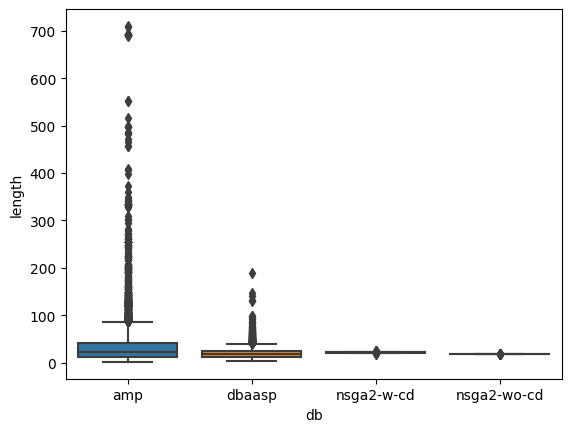

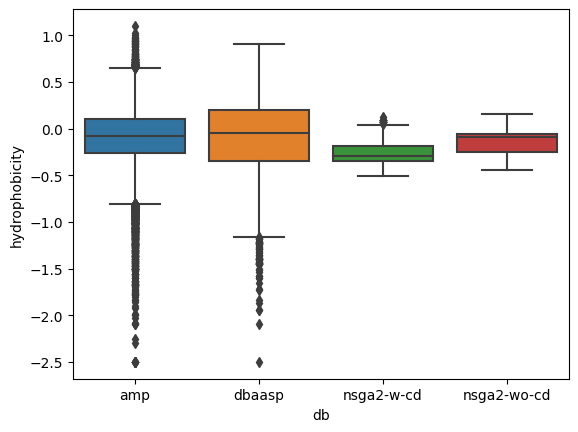

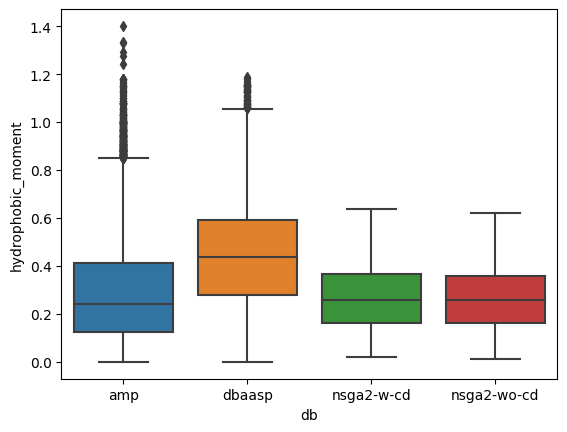

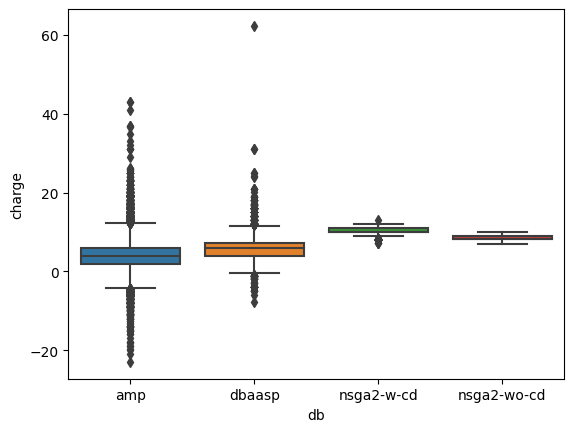

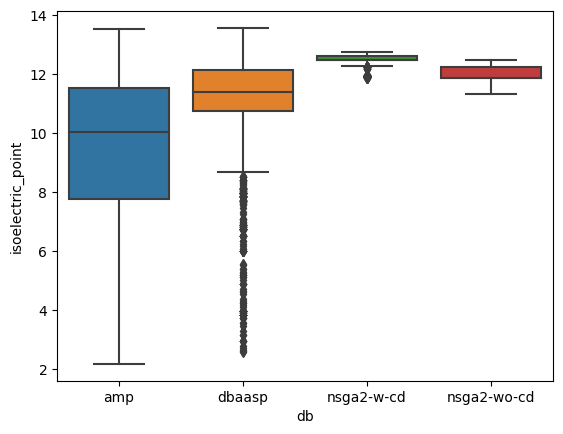

In [33]:
for pc_col in pc_cols:
    plt.figure()
    sns.boxplot(data=df_joined, x="db", y=pc_col)
    # break

In [34]:
df_joined.groupby('db')[pc_cols[0]].describe()    

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
amp,20313.0,33.342588,36.774125,2.0,12.0,23.0,42.0,710.0
dbaasp,4774.0,19.920612,10.500795,3.0,13.0,18.0,24.0,190.0
nsga2-w-cd,918.0,21.611111,0.592728,19.0,21.0,22.0,22.0,24.0
nsga2-wo-cd,973.0,18.985612,0.119147,18.0,19.0,19.0,19.0,19.0


In [35]:
df_joined.groupby('db')[pc_cols[1]].describe()    

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
amp,20313.0,-0.097064,0.332121,-2.500000,-0.258065,-0.074500,0.106667,1.100000
dbaasp,4774.0,-0.090353,0.401970,-2.500000,-0.345000,-0.048824,0.196923,0.902500
nsga2-w-cd,918.0,-0.260359,0.115865,-0.512381,-0.342727,-0.298095,-0.190000,0.120909
nsga2-wo-cd,973.0,-0.133265,0.100097,-0.439474,-0.247222,-0.093889,-0.059444,0.157222


In [36]:
df_joined.groupby('db')[pc_cols[2]].describe()    

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
amp,20313.0,0.291402,0.210223,5.242720e-17,0.124289,0.239702,0.414446,1.400997
dbaasp,4774.0,0.451417,0.228031,7.618362e-17,0.280315,0.436959,0.591116,1.187655
nsga2-w-cd,918.0,0.277301,0.136353,1.892606e-02,0.161903,0.256645,0.364773,0.635931
nsga2-wo-cd,973.0,0.261880,0.117348,1.268849e-02,0.160880,0.259387,0.356738,0.620867


In [37]:
df_joined.groupby('db')[pc_cols[3]].describe()    

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
amp,20313.0,3.978476,4.153387,-22.971,1.861,3.9960,5.995,42.987
dbaasp,4774.0,5.859261,3.270847,-7.883,3.995,5.8605,7.094,62.286
nsga2-w-cd,918.0,10.270275,0.821762,7.094,9.995,9.9950,10.994,12.994
nsga2-wo-cd,973.0,8.408774,0.508744,6.995,8.093,8.0930,8.995,9.995


### TODO
1. to score the dataset using score_pipline
2. to get the reference group data in HydrAMP (random, uniprot, positive, negative)

# Model Scoring

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class KMerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [' '.join(self.extract_kmers(seq)) for seq in X]

    def extract_kmers(self, sequence):
        # if len(sequence) < self.k:
        #     return []
        return [sequence[i:i+self.k] for i in range(len(sequence) - self.k + 1)]

In [40]:
hemo_scorer = joblib.load(HEMO_SCORE_PIPELINE_PATH)
mic_scorer = joblib.load(MIC_SCORE_PIPELNE_PATH)
amp_scorer = joblib.load(AMP_SCORE_PIPELINE_PATH)

df_joined = df_joined[~df_joined['db'].str.contains('ga')]

df_joined['p_hemo'] = hemo_scorer.predict_proba(df_joined['Sequence'].to_numpy())[:,1]
df_joined['p_mic'] = mic_scorer.predict_proba(df_joined['Sequence'].to_numpy())[:,1]
df_joined['p_amp'] = amp_scorer.predict_proba(df_joined['Sequence'].to_numpy())[:,1]

In [42]:
df_joined = pd.concat([
    df_joined,
    df_ga_1,
    df_ga_2
]).reset_index(drop=True)

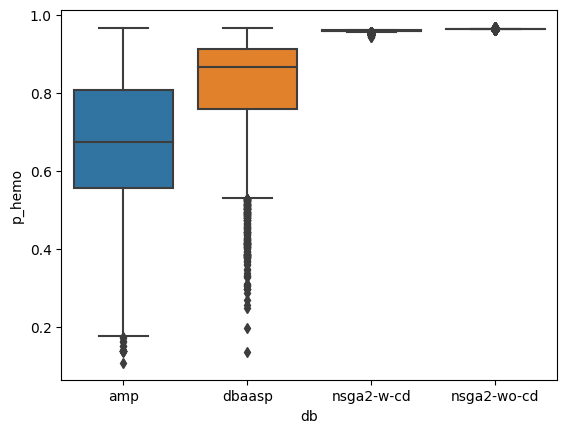

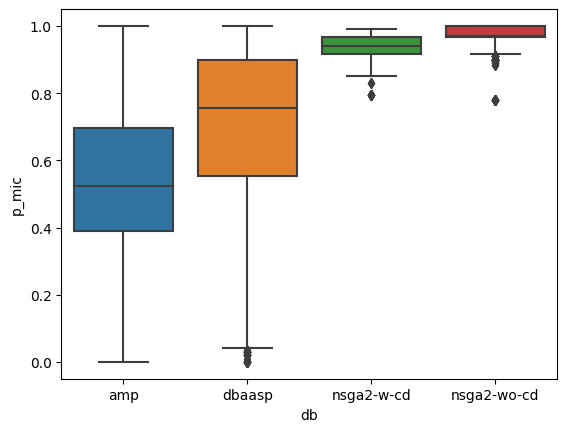

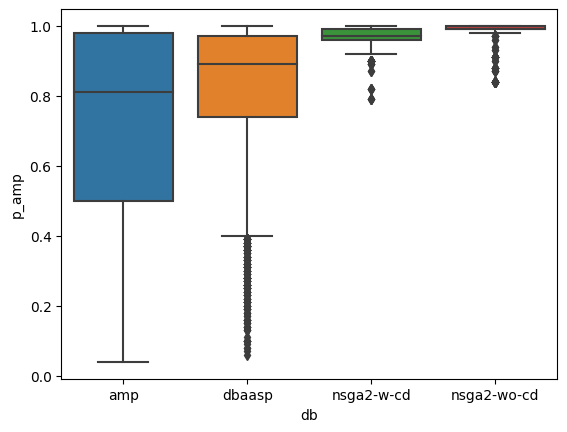

In [43]:
p_score_cols = ['p_hemo', 'p_mic', 'p_amp']
for p_col in p_score_cols:
    plt.figure()
    sns.boxplot(data=df_joined, x="db", y=p_col)